### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
import seaborn as sns
import sys
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

### Reading the CSV file

In [2]:
# Specifying the path
file_path = "C:/Users/Bilal But/Downloads/Python/DA3 - Intro to Machine Learning/Assignment 2/Boston/listings.csv.gz"

# Reading the CSV file 
df = pd.read_csv(file_path, encoding='UTF-8')
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,610920,https://www.airbnb.com/rooms/610920,20230324234210,2023-03-25,city scrape,La Jolla Beach Beauty ~ 3bd/2ba walk to beach/...,Perfect for family vacations or a romantic get...,"Bird Rock Village... shops, restaurants, coffe...",https://a0.muscache.com/pictures/54a9e30a-399a...,3028993,...,5.00,5.00,4.71,NaN,f,1,1,0,0,0.13
1,6,https://www.airbnb.com/rooms/6,20230324234210,2023-03-25,previous scrape,Stay in the 1st house EVER posted on Airbnb,"You read that right, this craftsman home was t...","We have the best Neighborhood in San Diego, in...",https://a0.muscache.com/pictures/miso/Hosting-...,29,...,4.97,4.77,4.80,STR-04545L,f,1,1,0,0,0.85
2,29967,https://www.airbnb.com/rooms/29967,20230324234210,2023-03-25,city scrape,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...",NaN,https://a0.muscache.com/pictures/76103867/c9b5...,129123,...,4.91,4.81,4.76,NaN,f,5,5,0,0,0.59
3,1166766,https://www.airbnb.com/rooms/1166766,20230324234210,2023-03-25,city scrape,Luxury Gated Mission Bay Estate,"<b>The space</b><br />Ultra luxury home, fully...",NaN,https://a0.muscache.com/pictures/d1226e08-7e26...,6388958,...,4.54,4.83,4.42,STR-00048L,f,3,3,0,0,0.22
4,1167130,https://www.airbnb.com/rooms/1167130,20230324234210,2023-03-25,city scrape,Luxury Tuscan Estate,Welcome to the largest home close to Downtown ...,Historic Old Town. Walking distance to numero...,https://a0.muscache.com/pictures/32076565/bef6...,6388958,...,4.83,4.79,4.58,STR-00538L,t,3,3,0,0,0.24


### Step-wise Data Preparation:
`Step 1:` Remove all the unwanted columns from our data
`Step 2:` Formatting columns and transforming them into our required shape
`Step 3:` Creating binary columns
`Step 4:` Handling missing values
`Step 5:` Factorizing columns
`Step 6:` Handling extreme values

In [3]:
# Drop unnecessary columns
drops = ["name", "listing_url", "last_scraped", "description", "host_thumbnail_url", "neighborhood_overview",
         "host_picture_url", "picture_url", "host_url", "host_about",
         "host_location", "host_total_listings_count", "bathrooms",
         "minimum_minimum_nights", "maximum_maximum_nights", "minimum_maximum_nights", "maximum_minimum_nights",
         "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "number_of_reviews_ltm",
         "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
         "calculated_host_listings_count_shared_rooms", "calendar_updated", "review_scores_accuracy",
         "review_scores_checkin", "review_scores_location", "review_scores_value", "review_scores_communication"]

df = df.drop(columns=drops)

In [4]:
df.shape

(12871, 46)

In [5]:
# Formatting columns
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [6]:
binary_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability",
               "instant_bookable"]
for col in binary_cols:
    df[col] = df[col].map({'f': 0, 't': 1})

In [7]:
# Filtering data so we have accommodates between 2-6
# Filtering and formatting the property types
df = df[(df['accommodates'] >= 2) & (df['accommodates'] <= 6)]
df = df[df['property_type'].isin(["Apartment", "Condominium", "Serviced apartment", "Entire loft",
                                  "Entire condominium (condo)", "Entire serviced apartment", "Entire home/apt",
                                  "Entire rental unit"])]

In [8]:
# Renaming property types
df['property_type'] = df['property_type'].replace({'Entire home/apt': 'Apartment',
                                                   'Entire serviced apartment': 'Apartment',
                                                   'Entire condominium (condo)': 'Condominium',
                                                   'Entire loft': 'Loft',
                                                   'Entire rental unit': 'Entire Unit'})

In [9]:
# Handling missing values for bathrooms_text
df = df[df['bathrooms_text'] != "null"]
df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.*\d*)')
df['bathrooms'] = df['bathrooms'].astype(float)

In [10]:
# Dealing with missing values
df['host_response_time'] = df['host_response_time'].dropna()
df['p_host_response_rate'] = df['host_response_rate'].fillna(1)

In [11]:
# Factorizing columns
df['f_property_type'] = pd.factorize(df['property_type'])[0]
df['f_room_type'] = pd.factorize(df['room_type'])[0]
df['f_neighbourhood_group_cleansed'] = pd.factorize(df['neighbourhood_group_cleansed'])[0]
df['f_neighbourhood_cleansed'] = pd.factorize(df['neighbourhood_cleansed'])[0]

In [12]:
# Dropping NAs
df = df.dropna(subset=['host_response_time'])

In [13]:
# Handling extreme values for price
df = df[df['price'] < 500]

In [14]:
# Creating ln_price
df['ln_price'] = np.log(df['price'])

### Plotting histograms for price and log price

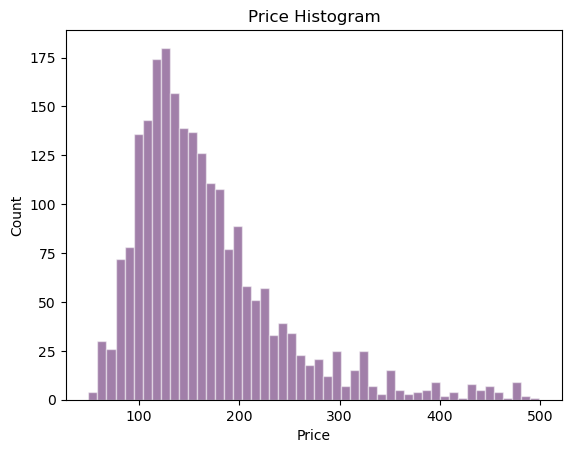

In [15]:
# Price Histogram
plt.hist(df['price'], bins=50, color='#440154', edgecolor='white', alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Histogram')
plt.show()

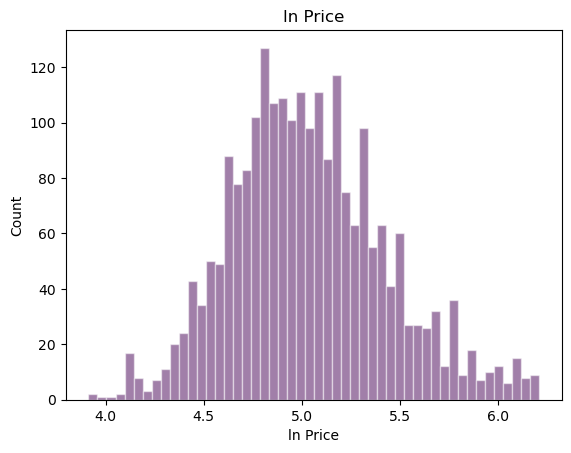

In [16]:
# Log of price
plt.hist(df['ln_price'], bins=50, color='#440154', edgecolor='white', alpha=0.5)
plt.xlabel('ln Price')
plt.ylabel('Count')
plt.title('ln Price')
plt.show()

In [19]:
# Fill missing values in the 'beds' column with the 'accommodates' column 
df['beds'].fillna(df['accommodates'], inplace=True)

# Fill missing values in the 'reviews_per_month' column with 1
df['reviews_per_month'].fillna(1, inplace=True)

In [21]:
df.drop(columns=['bathrooms_text', 'bedrooms', 'neighbourhood'], inplace=True)

In [23]:
df.drop(columns=['first_review', 'last_review', 'review_scores_rating', 'review_scores_cleanliness','license','neighbourhood_group_cleansed', 'host_neighbourhood'], inplace=True)

In [25]:
df['host_acceptance_rate'].fillna(1, inplace=True)

### Creating `Dummy Variables` for `Amenities`

In [27]:
df['amenities'] = df['amenities'].str.replace(r'\[|\]|\"|2013|2014|2019s|2019|\\\\u', '', regex=True)
df['amenities'] = df['amenities'].str.split(',')

# Defining my function to create dummy variables
def create_dummy(x, pattern):
    return 1 if any(re.search(pattern, item) for item in x) else 0

df['tv'] = df['amenities'].apply(lambda x: create_dummy(x, 'TV'))
df['heating'] = df['amenities'].apply(lambda x: create_dummy(x, 'Heating'))
df['wifi'] = df['amenities'].apply(lambda x: create_dummy(x, 'Wifi'))
df['coffee_maker'] = df['amenities'].apply(lambda x: create_dummy(x, 'Coffee maker'))
df['AC'] = df['amenities'].apply(lambda x: create_dummy(x, 'air conditioning'))
df['refrigerator'] = df['amenities'].apply(lambda x: create_dummy(x, 'Refrigerator'))
df['microwave'] = df['amenities'].apply(lambda x: create_dummy(x, 'Microwave'))
df['hot_water'] = df['amenities'].apply(lambda x: create_dummy(x, 'Hot water'))
df['long_term_stay'] = df['amenities'].apply(lambda x: create_dummy(x, 'Long term stays allowed'))
df['kitchen'] = df['amenities'].apply(lambda x: create_dummy(x, 'kitchen'))
df['pets_allowed'] = df['amenities'].apply(lambda x: create_dummy(x, 'Pets allowed'))
df['private_entrance'] = df['amenities'].apply(lambda x: create_dummy(x, 'Private entrance'))

df.drop(columns=['amenities', 'latitude', 'longitude'], inplace=True)


### We will now be creating boxplots to understand the relation between different variables and price

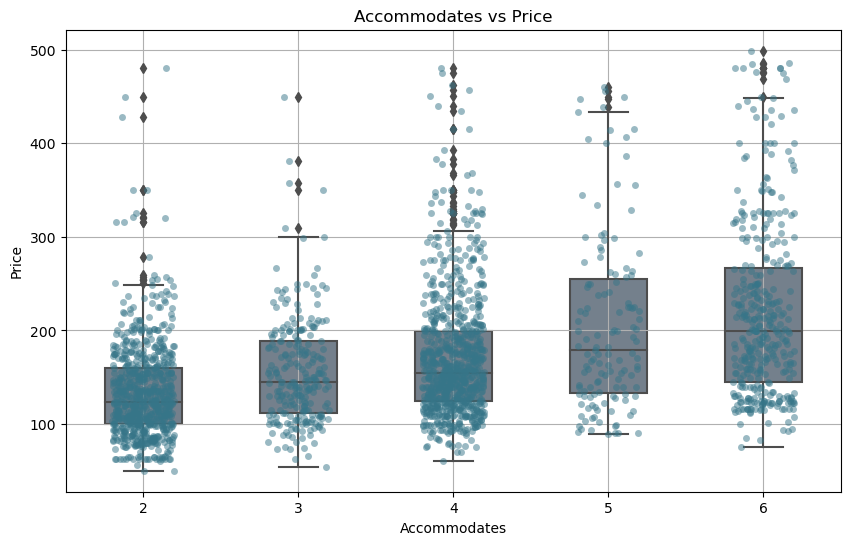

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accommodates', y='price', data=df, color='#708090', width=0.5)
sns.stripplot(x='accommodates', y='price', data=df, color='#367588', jitter=0.2, alpha=0.5)

plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Accommodates vs Price')
plt.grid(True)
plt.show()


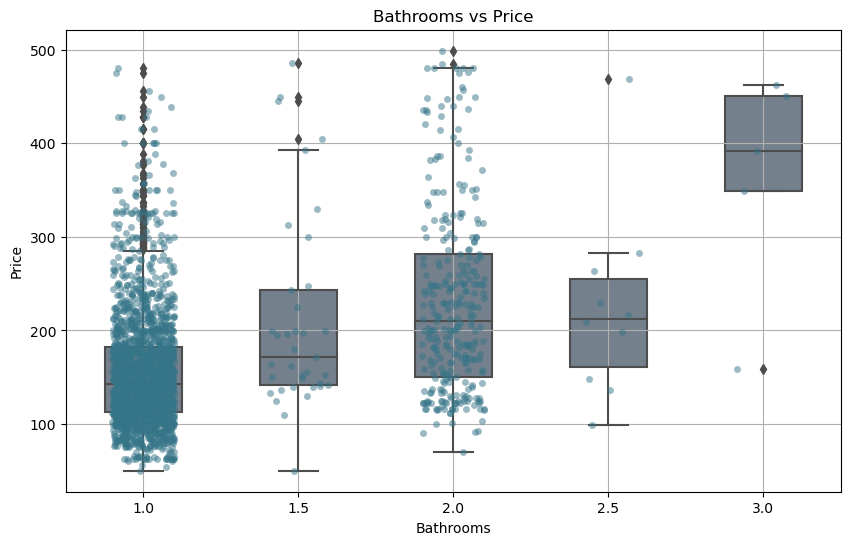

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='bathrooms', y='price', data=df, color='#708090', width=0.5)
sns.stripplot(x='bathrooms', y='price', data=df, color='#367588', jitter=0.2, alpha=0.5)

plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.title('Bathrooms vs Price')
plt.grid(True)
plt.show()


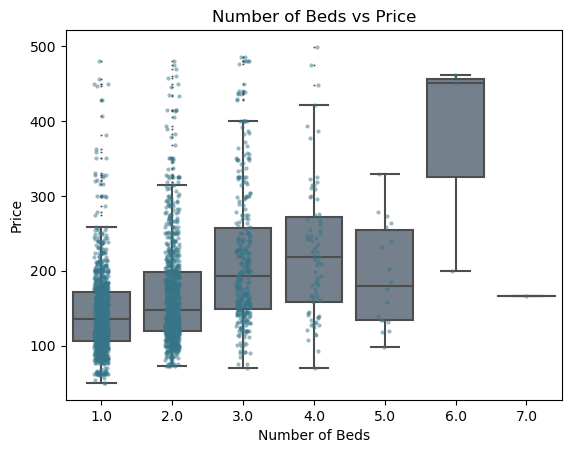

In [31]:
beds = sns.boxplot(data=df, x='beds', y='price', color='#708090', fliersize=0.5, width=0.8)
sns.stripplot(data=df, x='beds', y='price', jitter=True, alpha=0.5, color='#367588', size=3)

beds.set(xlabel='Number of Beds', ylabel='Price')
beds.set_title('Number of Beds vs Price')
plt.show()


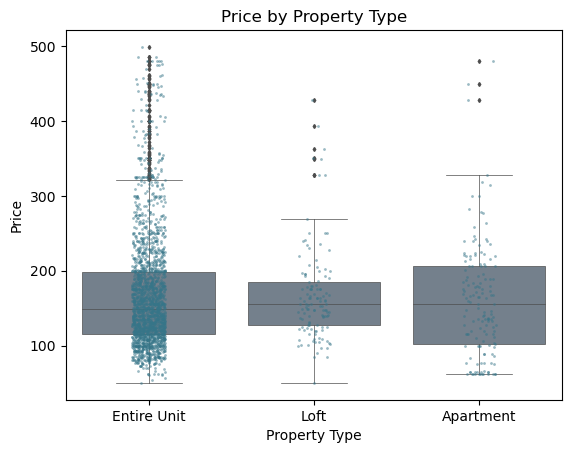

In [33]:
property_boxplot = sns.boxplot(data=df, x='property_type', y='price', color='#708090', linewidth=0.5, fliersize=2)
property_boxplot = sns.stripplot(data=df, x='property_type', y='price', jitter=True, alpha=0.5, color='#367588', size=2)

property_boxplot.set(xlabel='Property Type', ylabel='Price', title='Price by Property Type')
plt.show()


### Creating functions for paired variables and understanding the pattern with price

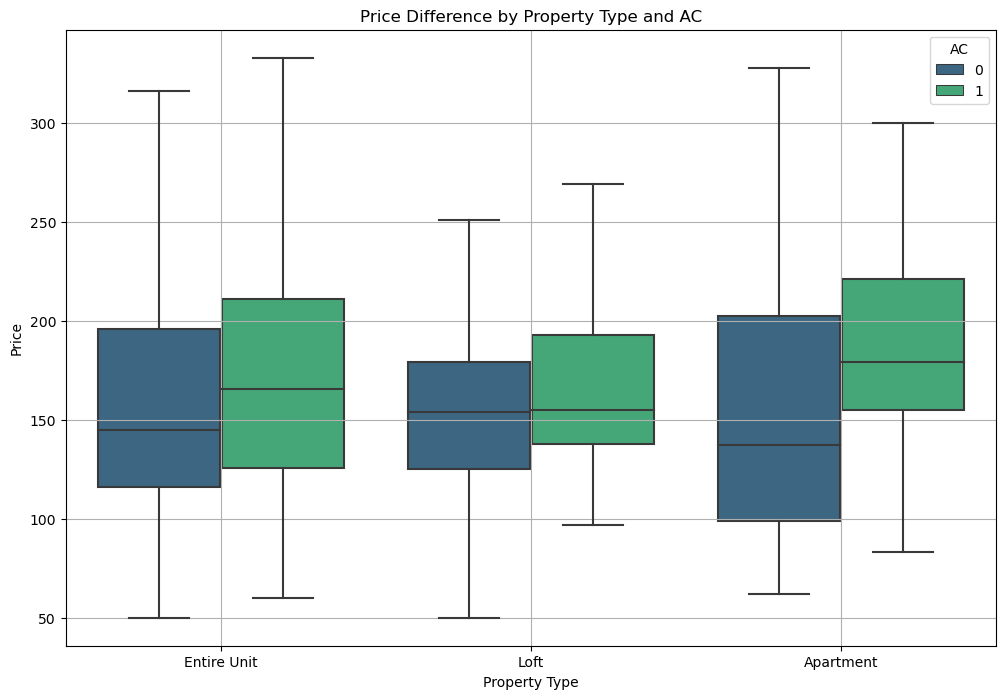

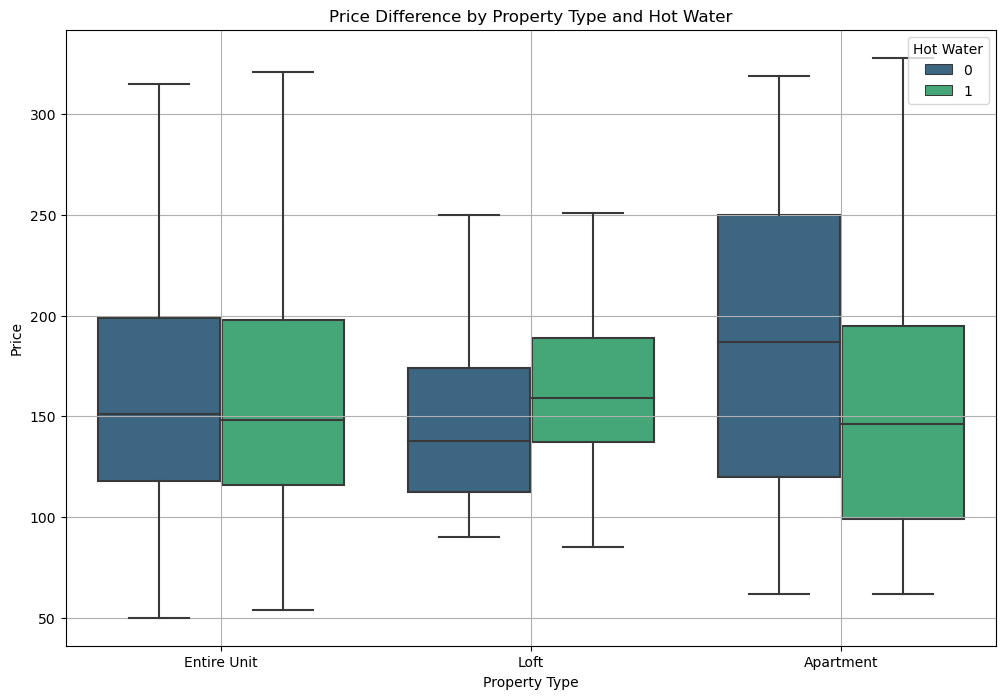

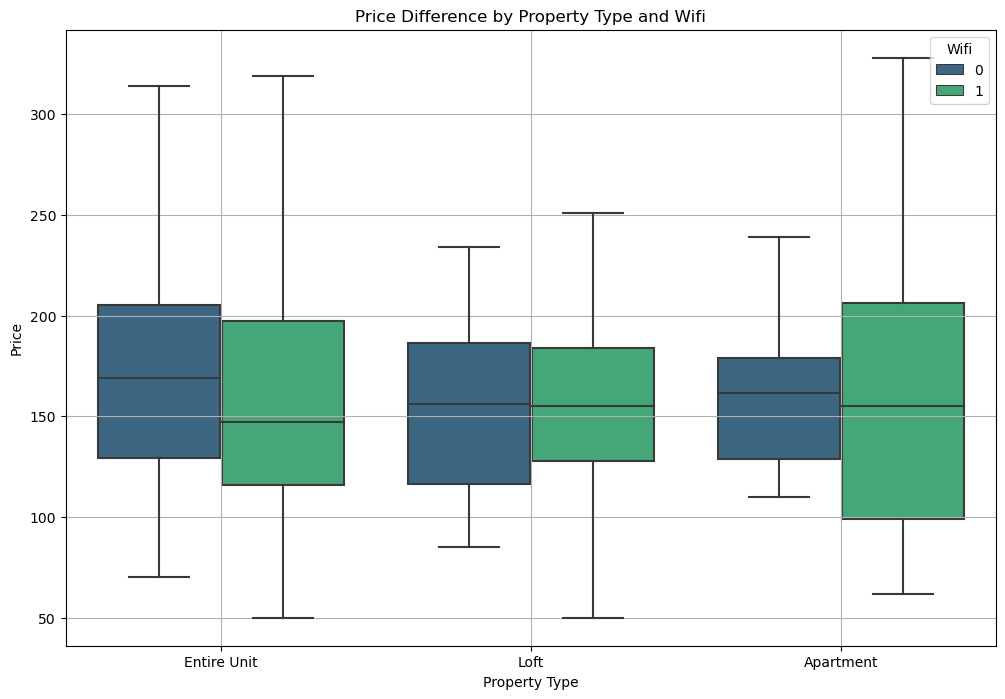

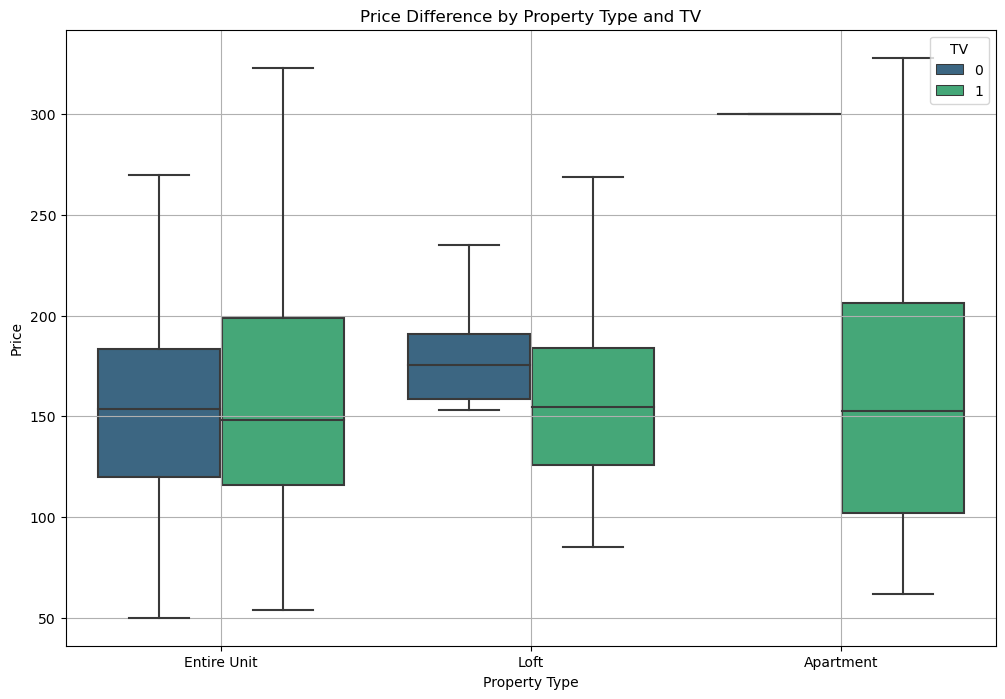

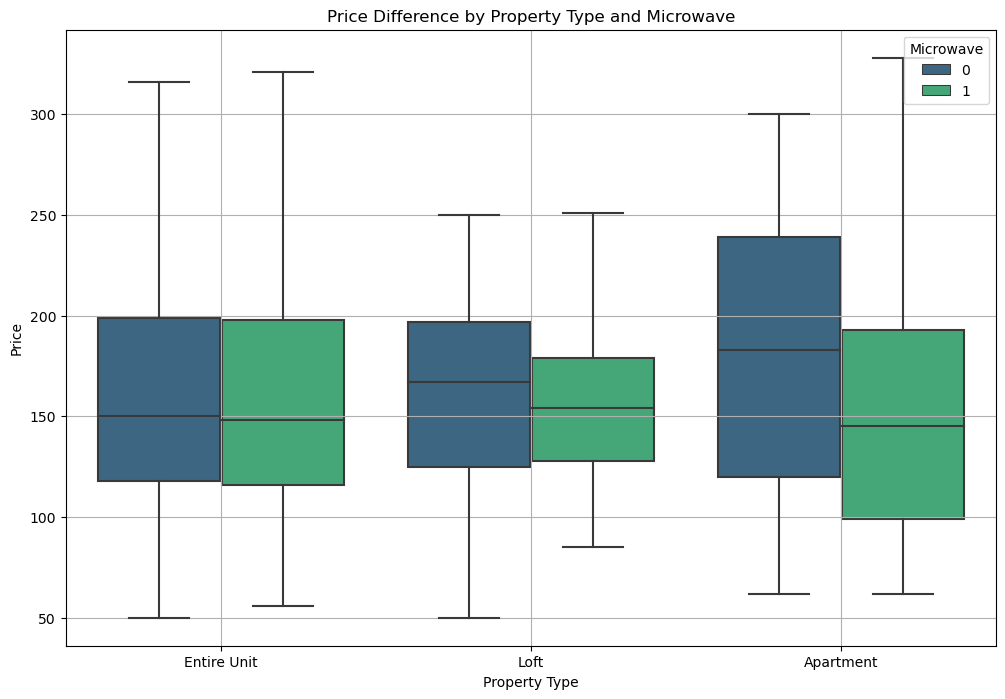

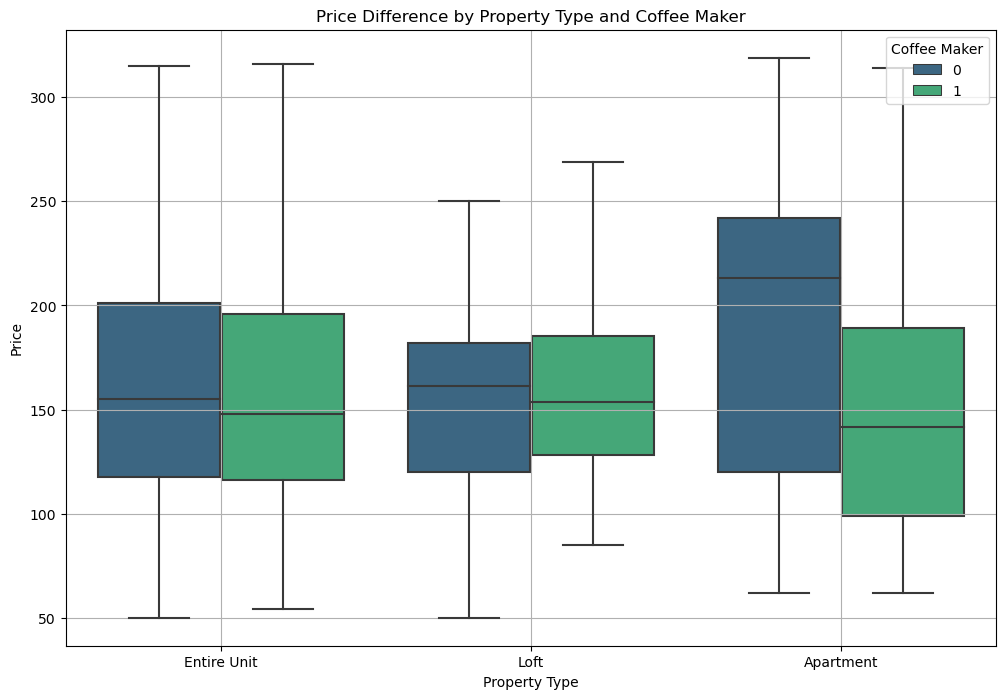

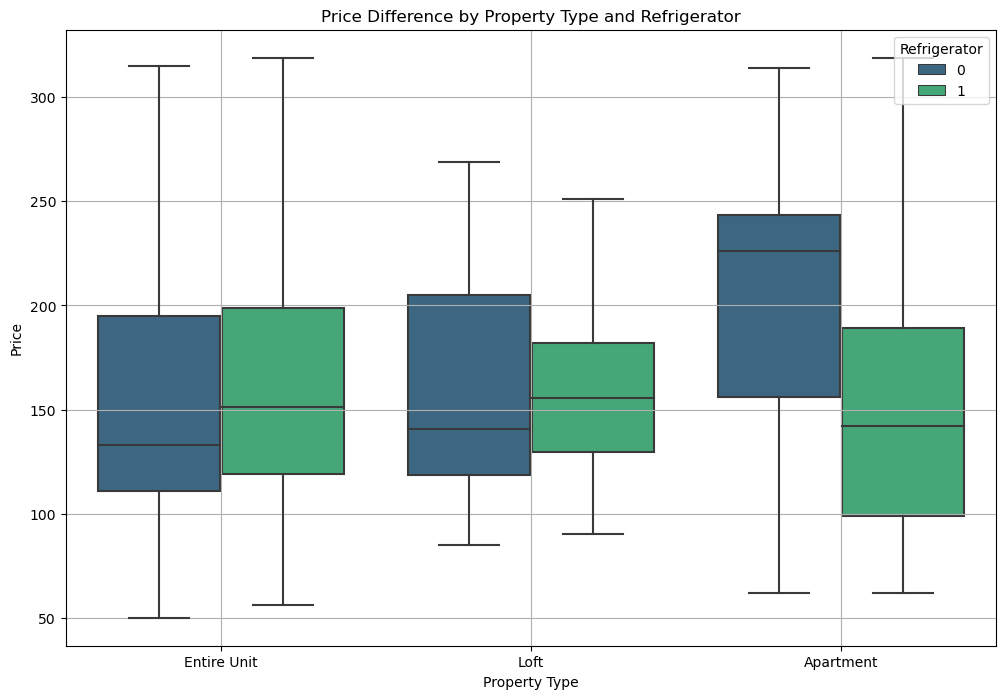

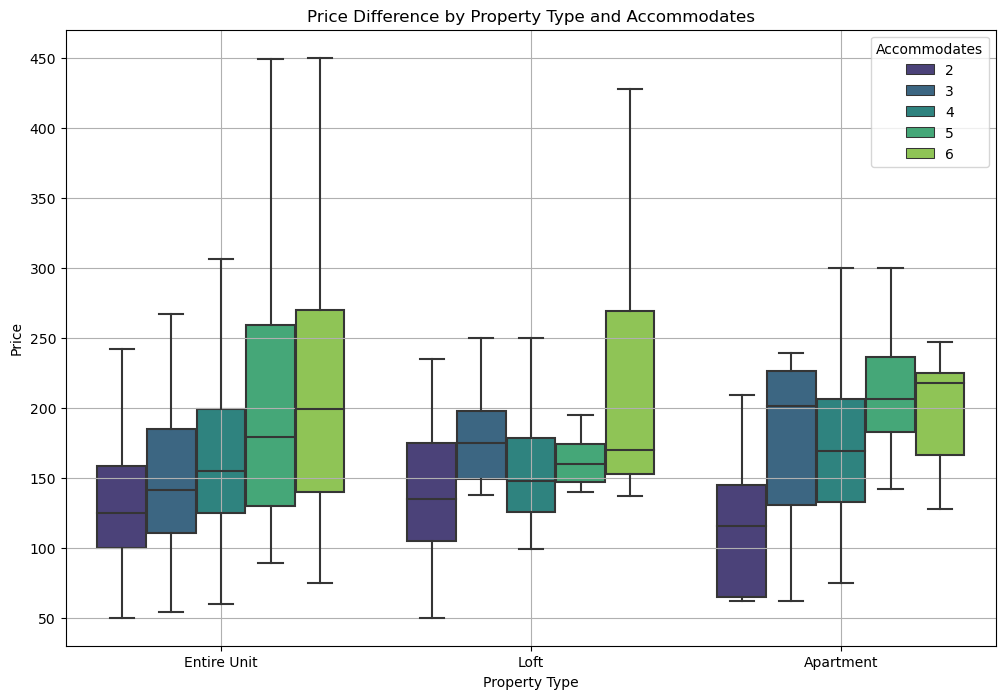

In [35]:
# Define a function for price difference by variables
def price_diff_by_variables(df, variable1, variable2, label1, label2):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=variable1, y='price', hue=variable2, data=df, palette='viridis', showfliers=False)    
# Add labels and title
    plt.xlabel(label1)
    plt.ylabel('Price')
    plt.title(f'Price Difference by {label1} and {label2}')    
# Adjust legend position
    plt.legend(title=label2, loc='upper right')  
# Show the plot
    plt.grid(True)
    plt.show()

# Call the function for each pair of variables
p1 = price_diff_by_variables(df, "property_type", "AC", "Property Type", "AC")
p2 = price_diff_by_variables(df, "property_type", "hot_water", "Property Type", "Hot Water")
p3 = price_diff_by_variables(df, "property_type", "wifi", "Property Type", "Wifi")
p4 = price_diff_by_variables(df, "property_type", "tv", "Property Type", "TV")
p5 = price_diff_by_variables(df, "property_type", "microwave", "Property Type", "Microwave")
p6 = price_diff_by_variables(df, "property_type", "coffee_maker", "Property Type", "Coffee Maker")
p7 = price_diff_by_variables(df, "property_type", "refrigerator", "Property Type", "Refrigerator")
p8 = price_diff_by_variables(df, "property_type", "accommodates", "Property Type", "Accommodates")


### Creating training and holdout datasets

In [37]:
data_train, data_holdout = train_test_split(df, train_size=0.7, random_state=42)

In [38]:
data_train.shape, data_holdout.shape

((1610, 52), (690, 52))

In [44]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "property_type",
    "bathrooms",
    "neighbourhood_cleansed",
]

# reviews
reviews = [
    "number_of_reviews",
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "AC:property_type",
    "wifi:property_type",
    "heating:property_type",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

In [45]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews
predictors_E = basic_vars + reviews + X1 + X2

### Using Random Forest to get RMSE values

In [46]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [49]:
import math

In [52]:
# using ravel() we flatten it to a one-dimensional data object. 
y.ravel().shape

(1610,)

In [53]:
rfr = RandomForestRegressor(random_state = 20240129)

In [54]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [55]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [56]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-63.742 total time=   0.0s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-58.214 total time=   0.0s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-64.290 total time=   0.0s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-69.401 total time=   0.0s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-68.774 total time=   0.0s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-64.883 total time=   0.0s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-60.153 total time=   0.0s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-66.886 total time=   0.0s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-72.771 total time=   0.0s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-70.746 total time=   0.0s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-65.748 total time=   0.0s
[CV 2/5] END max_fea

In [57]:
rf_model.cv_results_

{'mean_fit_time': array([0.11565742, 0.10187907, 0.10243335, 0.13757987, 0.12501454,
        0.1072051 , 0.14733782, 0.11421061, 0.10445333, 0.16462502,
        0.17144775, 0.14537768]),
 'std_fit_time': array([0.01236068, 0.01072996, 0.01177359, 0.01087609, 0.01511059,
        0.00865538, 0.00741168, 0.00554445, 0.00299674, 0.01003179,
        0.00825816, 0.00916518]),
 'mean_score_time': array([0.00773802, 0.00883932, 0.00746894, 0.00496993, 0.00796905,
        0.00909634, 0.00529952, 0.00660782, 0.00563293, 0.00848007,
        0.00789623, 0.00647769]),
 'std_score_time': array([0.00594668, 0.00330865, 0.00186465, 0.00284745, 0.00757977,
        0.00753252, 0.00418697, 0.00042767, 0.00162333, 0.00330772,
        0.00424137, 0.00783429]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [58]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [59]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [60]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-64.884036
1,6,10,-67.087759
2,6,15,-68.387451
3,8,5,-63.496647
4,8,10,-65.740722
5,8,15,-66.802052
6,10,5,-63.178463
7,10,10,-65.220136
8,10,15,-65.913941
9,12,5,-62.700355


In [61]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,64.88,67.09,68.39
8,63.50,65.74,66.80
10,63.18,65.22,65.91
12,62.70,64.42,65.35


In [62]:
rf_model.best_score_

-62.70035471159896

In [63]:
rf_model.best_params_

{'max_features': 12, 'min_samples_leaf': 5}

In [64]:
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

In [65]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.37792802e-02, 2.51017958e-03, 3.41060968e-03,
       0.00000000e+00, 1.29116706e-03, 0.00000000e+00, 4.13861384e-02,
       2.91523868e-06, 3.72302406e-03, 5.77456421e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.36479256e-03, 2.11881616e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.89887685e-02, 0.00000000e+00, 0.00000000e+00, 1.14433863e-03,
       3.74141547e-03, 6.00665205e-05, 0.00000000e+00, 4.13864944e-02,
       0.00000000e+00, 0.00000000e+00, 7.16025778e-05, 6.47583008e-03,
       1.74533352e-03, 1.97519885e-03, 3.15025691e-03, 5.87250369e-03,
       0.00000000e+00, 1.13779866e-04, 4.47288093e-02, 2.25761936e-03,
       3.45692579e-03, 0.00000000e+00, 4.89106229e-05, 1.76971579e-03,
       0.00000000e+00, 0.00000000e+00, 8.19849215e-03, 4.58245154e-03,
       4.04171456e-02, 1.24626430e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [66]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire Unit],0.013779
property_type[T.Loft],0.002510
neighbourhood_cleansed[T.Balboa Park],0.003411
neighbourhood_cleansed[T.Bay Ho],0.000000
...,...
neighbourhood_cleansed[T.West University Heights],0.004003
accommodates,0.209686
beds,0.155857
bathrooms,0.211676


In [67]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [68]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bathrooms,21.2%,21.2%
1,accommodates,21.0%,42.1%
2,beds,15.6%,57.7%
3,number_of_reviews,11.9%,69.6%
4,neighbourhood_cleansed[T.Mission Bay],4.5%,74.0%
5,neighbourhood_cleansed[T.La Jolla],4.1%,78.2%
6,neighbourhood_cleansed[T.Bird Land],4.1%,82.3%
7,neighbourhood_cleansed[T.Pacific Beach],4.0%,86.4%
8,neighbourhood_cleansed[T.East Village],1.9%,88.3%
9,neighbourhood_cleansed[T.University City],1.4%,89.6%


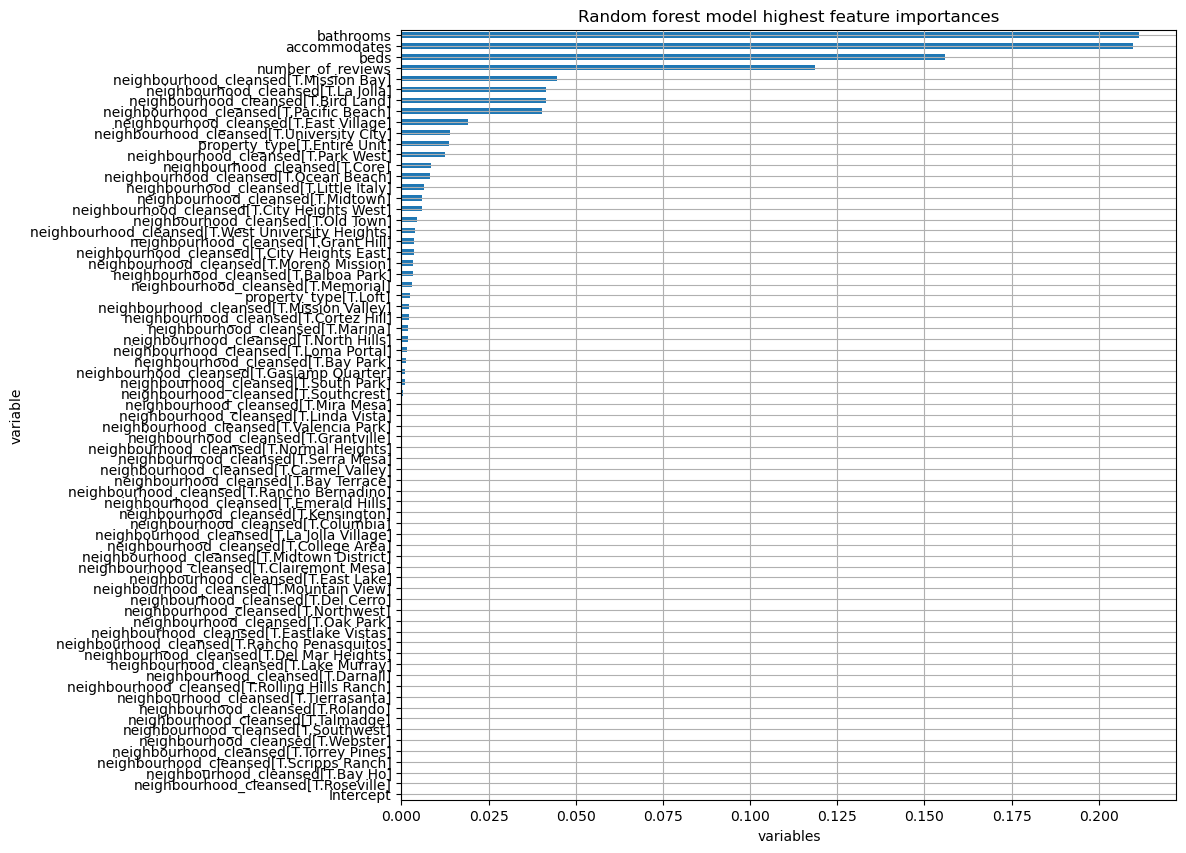

In [69]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [70]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

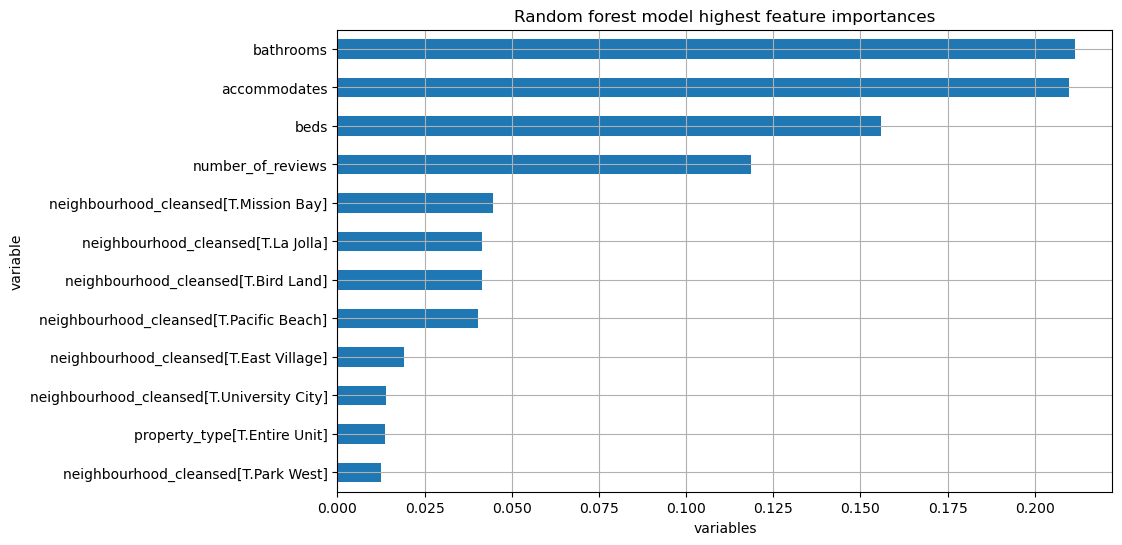

In [71]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False);

In [72]:
predictors_2

['accommodates',
 'beds',
 'property_type',
 'bathrooms',
 'neighbourhood_cleansed',
 'number_of_reviews']

In [73]:
# Specify the specific column names
specific_categorical_columns = ['property_type', 'room_type', 'bathrooms', 'neighbourhood_cleansed']

# Filter the columns based on the specified names
categorical_columns = [col for col in predictors_2 if col in specific_categorical_columns]


In [74]:
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [75]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [76]:
data_train.columns

Index(['id', 'scrape_id', 'source', 'host_id', 'host_name', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'bathrooms',
       'p_host_response_rate', 'f_property_type', 'f_room_type',
       'f_neighbourhood_group_cleansed', 'f_neighbourhood_cleansed',
       'ln_price', 'tv', 'heating', 'wifi', 'coffee_maker', 'AC',
       'refrigerator', 'microwave', 'hot_water', 'long_term_stay', 'kitchen',
       'pets_allowe

In [77]:
data_train[predictors_2].dtypes


accommodates                int64
beds                      float64
property_type              object
bathrooms                 float64
neighbourhood_cleansed     object
number_of_reviews           int64
dtype: object

In [78]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 281 ms
Wall time: 274 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'bathrooms',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

### Checking variable importance and then grouping them into categories to understand the pattern and see what affects our price variable the most

In [79]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 859 ms
Wall time: 867 ms


In [80]:
result

{'importances_mean': array([0.13549612, 0.0444141 , 0.0084495 , 0.11661741, 0.17284245,
        0.03481881]),
 'importances_std': array([0.0102561 , 0.00716067, 0.00333563, 0.01486826, 0.00981074,
        0.00583811]),
 'importances': array([[0.15173864, 0.14265042, 0.13353992, 0.12984556, 0.14225232,
         0.14599812, 0.11336752, 0.13018829, 0.13509683, 0.13028354],
        [0.04549106, 0.04714338, 0.04813298, 0.03686287, 0.03762446,
         0.0580771 , 0.05058174, 0.03199789, 0.04209803, 0.04613143],
        [0.00910361, 0.00893   , 0.00612399, 0.01053268, 0.00935584,
         0.0069005 , 0.00151356, 0.01005191, 0.006866  , 0.01511695],
        [0.13280795, 0.10718949, 0.11396339, 0.12181828, 0.12837738,
         0.1404021 , 0.09012242, 0.11186273, 0.12215208, 0.09747828],
        [0.17783388, 0.18788338, 0.18978381, 0.17393884, 0.17350745,
         0.15776643, 0.1733085 , 0.16393933, 0.16543686, 0.16502607],
        [0.03141725, 0.04856069, 0.03665023, 0.03040146, 0.03032406,
  

In [81]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.135496
beds,0.044414
property_type,0.008450
bathrooms,0.116617
neighbourhood_cleansed,0.172842
number_of_reviews,0.034819


In [85]:
grouped = [
    "property_type",
    "bathrooms",
    "accommodates",
    "beds",
    "neighbourhood_cleansed",
]

In [86]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [87]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,17.3%,17.3%
1,accommodates,13.5%,30.8%
2,bathrooms,11.7%,42.5%
3,beds,4.4%,46.9%
4,property_type,0.8%,47.8%


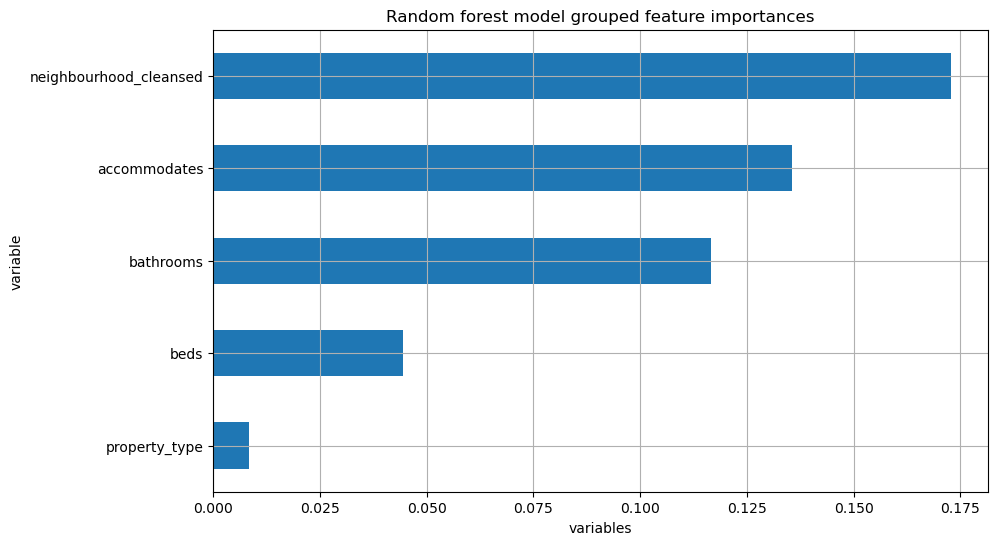

In [88]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [89]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,0.172842,0.211676
1,accommodates,0.135496,0.421363
2,bathrooms,0.116617,0.577219
3,beds,0.044414,0.695731
4,number_of_reviews,0.034819,0.740460
5,property_type,0.008450,0.781847


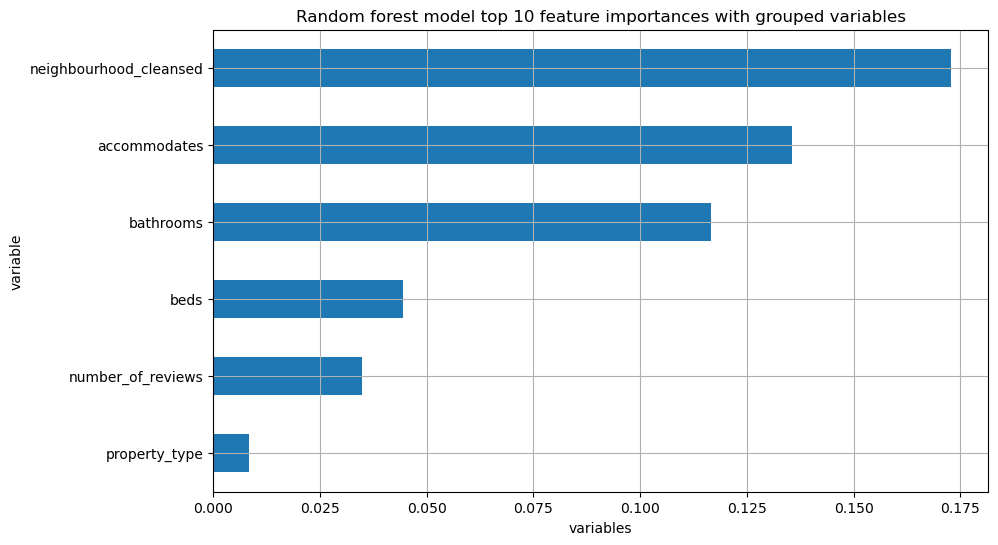

In [90]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

In [92]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

In [93]:
accomodates_pdp

{'grid_values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'average': array([[150.58904615, 164.69344291, 172.49285788, 183.38212782,
         194.51469168]])}

In [94]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,150.589046
1,3,164.693443
2,4,172.492858
3,5,183.382128
4,6,194.514692


### Plotting partial dependance plots

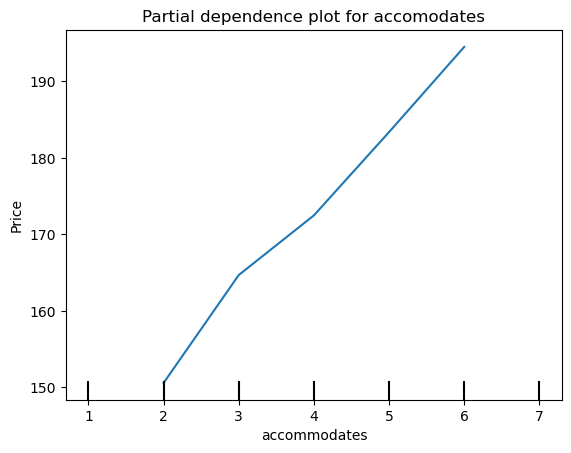

In [170]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for accomodates')
plt.ylabel('Price')
plt.show();

In [98]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

In [100]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [101]:
data_holdout_w_prediction.iloc[0:5, -5:]

,kitchen,pets_allowed,private_entrance,predicted_price,is_low_size
4920,0,1,1,162.614800,large apt
11591,0,1,0,198.691039,large apt
1340,0,1,1,137.564203,small apt
9549,0,0,1,182.103861,large apt
1913,0,1,0,181.871349,large apt


In [102]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    61.055461
small apt    47.375965
dtype: float64

In [103]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [105]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [106]:
accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,63.58,187.75,0.34
small apt,46.95,140.21,0.33


In [114]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.neighbourhood_cleansed.isin(
        [
            "Mission Bay",
            "East Village",
            "Pacific Beach",
            "Ocean Beach",
            "North Hills",
        ]
    )
].groupby("neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

,rmse,mean_price,rmse_norm
neighbourhood_cleansed,,,
East Village,62.26,172.37,0.36
Mission Bay,62.71,199.81,0.31
North Hills,34.28,148.34,0.23
Ocean Beach,40.19,141.91,0.28
Pacific Beach,73.02,193.86,0.38


In [115]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.property_type.isin(["Apartment", "House"])
].groupby("property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

,rmse,mean_price,rmse_norm
property_type,,,
Apartment,38.45,161.25,0.24


In [116]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,56.88,166.88,0.34


In [123]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

In [124]:
type_rows

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
Type,------,------,------
Borough,------,------,------
------,------,------,------


In [125]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
large apt,63.58,187.75,0.34
small apt,46.95,140.21,0.33
Type,------,------,------
Apartment,38.45,161.25,0.24
Borough,------,------,------
East Village,62.26,172.37,0.36
Mission Bay,62.71,199.81,0.31
North Hills,34.28,148.34,0.23
Ocean Beach,40.19,141.91,0.28


### Using OLS Regression model to calculate RMSE values

In [167]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
ols_model = LinearRegression().fit(X,y)
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)
y_hat = ols_model.predict(X)
ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

60.73316772274322

In [128]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [129]:
ols_model_coeffs_df

,ols_coefficient
Intercept,0.000
property_type[T.Entire Unit],-11.144
property_type[T.Loft],-10.141
neighbourhood_cleansed[T.Balboa Park],-28.835
neighbourhood_cleansed[T.Bay Ho],-7.990
...,...
neighbourhood_cleansed[T.West University Heights],-13.099
accommodates,11.676
beds,9.762
bathrooms,48.056


### Using LASSO model to calculate our RMSE values

In [131]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [132]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [133]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [134]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-64.583 total time=   0.0s
[CV 2/5] END ......................alpha=0.05;, score=-58.694 total time=   0.0s
[CV 3/5] END ......................alpha=0.05;, score=-60.765 total time=   0.0s
[CV 4/5] END ......................alpha=0.05;, score=-64.765 total time=   0.0s
[CV 5/5] END ......................alpha=0.05;, score=-64.081 total time=   0.0s
[CV 1/5] END .......................alpha=0.1;, score=-64.465 total time=   0.0s
[CV 2/5] END .......................alpha=0.1;, score=-57.860 total time=   0.0s
[CV 3/5] END .......................alpha=0.1;, score=-60.379 total time=   0.0s
[CV 4/5] END .......................alpha=0.1;, score=-64.020 total time=   0.0s
[CV 5/5] END .......................alpha=0.1;, score=-64.205 total time=   0.0s
[CV 1/5] END ......................alpha=0.15;, score=-64.595 total time=   0.0s
[CV 2/5] END ......................alpha=0.15;, s

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [135]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
neighbourhood_cleansed[T.Bird Land],-28.991
neighbourhood_cleansed[T.Core],9.998
neighbourhood_cleansed[T.La Jolla],0.702
neighbourhood_cleansed[T.Little Italy],4.495
neighbourhood_cleansed[T.Midtown],17.419
...,...
AC:property_type[Entire Unit],5.491
wifi:property_type[Apartment],8.467
wifi:property_type[Entire Unit],-13.163
heating:property_type[Apartment],-31.364


In [136]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.15, l1_ratio=1)

In [137]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.03855925, 0.02160773, 0.0139472 , 0.01277976, 0.0126687 ]),
 'std_fit_time': array([0.01819777, 0.00151254, 0.00169061, 0.00246183, 0.00393019]),
 'mean_score_time': array([0.00058494, 0.0006011 , 0.00060554, 0.00039978, 0.00065746]),
 'std_score_time': array([0.00047837, 0.0004908 , 0.00049888, 0.00048963, 0.00054689]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-64.58261598, -64.46549516, -64.59475839, -64.68964948,
        -64.7078907 ]),
 'split1_test_score': array([-58.69425197, -57.86049322, -57.29266309, -57.14533517,
        -57.07673412]),
 'split2_test_score': array([-60.76491348, -60.37873349, -60.35738907, -60.34928203,
        -60.36344999]),
 'split3_test_score': array([-64.76455955, -64.

In [138]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

62.16771186133881

### Using CART to calculate RMSE values

In [140]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [141]:
cart_model = DecisionTreeRegressor(random_state=20240129)

In [142]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [143]:
ccp_alphas

array([0.00000000e+00, 3.10559006e-05, 1.03519669e-04, ...,
       2.10124970e+02, 2.52610340e+02, 7.78386850e+02])

In [144]:
ccp_alphas.shape

(1039,)

In [145]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....ccp_alpha=2.0739302967563953;, score=-77.027 total time=   0.0s
[CV 2/5] END ....ccp_alpha=2.0739302967563953;, score=-77.100 total time=   0.0s
[CV 3/5] END ....ccp_alpha=2.0739302967563953;, score=-75.086 total time=   0.0s
[CV 4/5] END ....ccp_alpha=2.0739302967563953;, score=-80.779 total time=   0.0s
[CV 5/5] END ....ccp_alpha=2.0739302967563953;, score=-72.070 total time=   0.0s
[CV 1/5] END ...ccp_alpha=0.28671232149492926;, score=-78.055 total time=   0.0s
[CV 2/5] END ...ccp_alpha=0.28671232149492926;, score=-78.754 total time=   0.0s
[CV 3/5] END ...ccp_alpha=0.28671232149492926;, score=-76.506 total time=   0.0s
[CV 4/5] END ...ccp_alpha=0.28671232149492926;, score=-82.712 total time=   0.0s
[CV 5/5] END ...ccp_alpha=0.28671232149492926;, score=-73.548 total time=   0.0s
[CV 1/5] END ...ccp_alpha=0.11966873706003087;, score=-78.274 total time=   0.0s
[CV 2/5] END ...ccp_alpha=0.11966873706003087;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240129),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 3.10559006e-05, 1.03519669e-04, ...,
       2.10124970e+02, 2.52610340e+02, 7.78386850e+02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [146]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

76.41248476524403

### Using GBM to calculate RMSE values

In [148]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [149]:
# Specify the specific column names
specific_categorical_columns = ['property_type', 'room_type', 'bathrooms', 'neighbourhood_cleansed']

# Filter the columns based on the specified names
categorical_columns = [col for col in predictors_2 if col in specific_categorical_columns]


In [150]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [151]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   7.6s
CPU times: total: 500 ms
Wall time: 7.63 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'bathrooms',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [152]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([0.48775725, 0.92826924, 0.81604996, 1.12673125]),
 'std_fit_time': array([0.05891124, 0.07420658, 0.15042617, 0.08290467]),
 'mean_score_time': array([0.01823897, 0.01404619, 0.01049647, 0.01656408]),
 'std_score_time': array([0.01267347, 0.00844805, 0.00275476, 0.00171232]),
 'param_max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 300, 200, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 200},
  {'max_depth': 5, 'n_estimators': 300},
  {'max_depth': 10, 'n_estimators': 200},
  {'max_depth': 10, 'n_estimators': 300}],
 'split0_test_score': array([-61.17340734, -61.624329  , -61.05703399, -61.90937004]),
 'split1_test_score': array([-54.36962586, -54.69756117, -54.24081052, -55.81189396]),
 'split2_test_score': array(

In [153]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=200)

In [154]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [155]:
gbm_rmse

59.25306625758926

In [168]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'CART', 'random forest', 'GBM'],
              'CV RMSE': [ols_rmse, lasso_rmse, cart_rmse, all_holdout.rmse[0], gbm_rmse]})

,model,CV RMSE
0,OLS,60.733168
1,LASSO,62.167712
2,CART,76.412485
3,random forest,56.880000
4,GBM,59.253066
